# Customer Segmentation using Clustering
***

This mini-project is based on [this blog post](https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

## Data 

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
#!pip install xlrd
filename = "./WineKMC.xls"

# Note: .xlsx type files no longer supported for pd.read_excel() from the xlrd library

In [4]:
df_offers = pd.read_excel(filename, sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel(filename, sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [6]:
print(len(df_offers), 'offers')
print(len(df_transactions), 'transactions')
print(df_transactions.customer_name.nunique(), 'unique customers')

32 offers
324 transactions
100 unique customers


Check for null/missing values:

In [7]:
df_transactions.isna().sum()

customer_name    0
offer_id         0
n                0
dtype: int64

In [8]:
df_offers.isna().sum()

offer_id     0
campaign     0
varietal     0
min_qty      0
discount     0
origin       0
past_peak    0
dtype: int64

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [pivot_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as NaN. Read the documentation to develop your solution.</p>
</div>

In [9]:
#your turn
df_customer_profile = df_transactions.drop(['n'],axis=1)
df_customer_profile.head()

,customer_name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


In [10]:
transactions_encoded = pd.get_dummies(df_transactions.offer_id, prefix='offer_')
transactions_encoded.head()
offer_names = transactions_encoded.columns

In [11]:
print(len(transactions_encoded), len(df_customer_profile))

324 324


In [12]:
df_customer_profile = df_customer_profile.join(transactions_encoded)
df_customer_profile.drop(labels=['offer_id'], axis=1, inplace=True)
df_customer_profile.head()

,customer_name,offer__1,offer__2,offer__3,offer__4,offer__5,offer__6,offer__7,offer__8,offer__9,...,offer__23,offer__24,offer__25,offer__26,offer__27,offer__28,offer__29,offer__30,offer__31,offer__32
0,Smith,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Smith,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Johnson,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Aggregate dataframe on `customer_name` (i.e. aggregate customers' multiple purchases)

In [13]:
df_customer_profile = df_customer_profile.pivot_table(index=['customer_name'],aggfunc=np.sum)
df_customer_profile = df_customer_profile.reindex(offer_names, axis=1)

In [14]:
df_customer_profile

,offer__1,offer__2,offer__3,offer__4,offer__5,offer__6,offer__7,offer__8,offer__9,offer__10,...,offer__23,offer__24,offer__25,offer__26,offer__27,offer__28,offer__29,offer__30,offer__31,offer__32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the **Elbow method**, the **Silhouette method** and the **gap statistic**.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the **sum-of-squares error** in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [15]:
# your turn

The better clusterings will give us `minimum values` of $SS$.  
This is because we would like to have clusters made up of points s.t. their distance to their centroid is small.

In [16]:
x_cols = df_customer_profile.to_numpy()

In [17]:
from sklearn.cluster import KMeans

In [18]:
K = range(2,30)
num_k = len(K)
SS = np.zeros(num_k)

# run KMeans for each K
for i in range(num_k):
    # fit model
    kmeans = KMeans(n_clusters=K[i], tol=1e-4, random_state=0).fit(x_cols)
    # get score
    SS[i] = kmeans.inertia_ # kmeans.score(x_cols)

print("SS values:",SS)

SS values: [251.46031746 227.625      214.87996032 207.14976077 198.7499951
 186.99147727 177.9788961  173.02916667 163.74242424 159.25454545
 155.08699634 149.6991342  141.86168831 137.98766234 135.69805195
 130.85411255 128.37619048 123.43690476 119.80714286 114.17738095
 112.67911255 106.80818071 105.7984127  101.94285714  96.99989177
  95.04285714  89.13571429  89.34285714]


Plot $SS$ vs. $K$ to find the **elbow point** (value of $K$ at which the plot starts descending much more slowly)

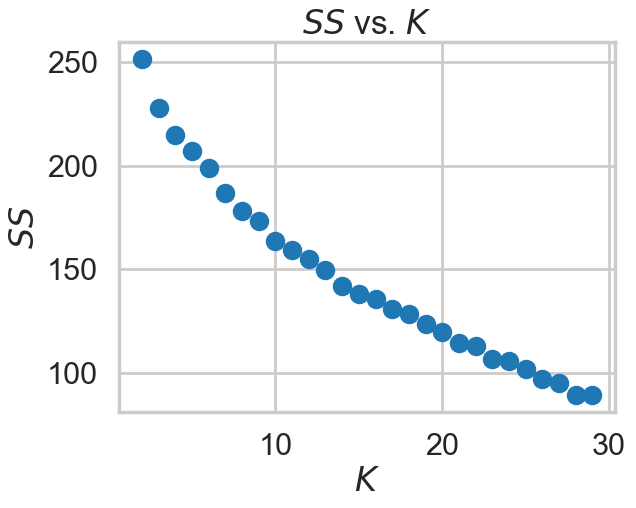

In [19]:
plt.scatter(K,SS)
plt.xlabel('$K$')
plt.ylabel('$SS$')
plt.title("$SS$ vs. $K$")
plt.show()

From values $K \in [2,10]$, it appears at $K=9$ values of $SS$ start decreasing slower (smaller slope).  
Let's ignore the plot for values $K>10$, since the model will begin to overfit the clusters as the sample size is only $n=100$.  
Let's examine how many points are in each cluster for $K=9$. 

In [20]:
# refit model with K=9
k = 9
kmeans = KMeans(n_clusters=k, tol=1e-4, random_state=0).fit(x_cols)

In [21]:
kmeans.labels_

array([8, 7, 1, 0, 0, 7, 1, 4, 5, 0, 2, 1, 0, 5, 5, 1, 5, 1, 8, 5, 0, 4,
       5, 2, 1, 6, 6, 5, 7, 1, 0, 4, 5, 3, 8, 4, 5, 0, 2, 0, 1, 1, 4, 7,
       0, 3, 0, 0, 5, 2, 5, 6, 2, 1, 0, 4, 1, 0, 8, 4, 7, 4, 5, 8, 8, 1,
       1, 5, 2, 7, 6, 7, 3, 0, 7, 0, 1, 0, 8, 1, 5, 5, 6, 1, 4, 4, 8, 5,
       5, 4, 3, 8, 5, 0, 6, 7, 4, 6, 3, 7])

In [22]:
pts_per_cluster = pd.Series(kmeans.labels_).value_counts().sort_index()

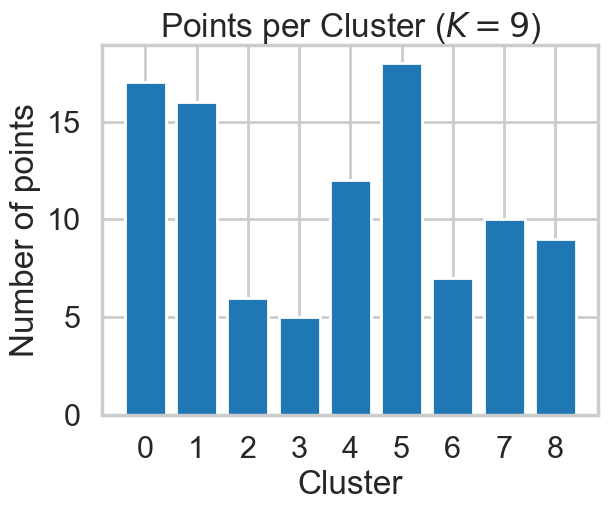

In [23]:
plt.bar(range(k), pts_per_cluster, tick_label=range(k))
plt.title("Points per Cluster ($K=9$)")
plt.xlabel("Cluster")
plt.ylabel("Number of points")
plt.show()

A challenge in choosing K with the Elbow method, is that it's not entirely clear where values of $SS$ approach an *elbow*.  
Obviously values of $SS$ will continue to decrease if we increase the number of clusters $K$, but that also means that we begin to overfit the model. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$
$$a_{x_{i}} = \frac{1}{n_{k}}\sum_{x_{j} \in C_{k}} \rm{d}(x_{i}, x_{j}), \quad \text{where } x_{i}\in C_{k}$$
$$b_{x_{i}} = \min_{C_{l}} \left( \frac{1}{n_{l}}\sum_{x_{j} \in C_{l}} \rm{d}(x_{i}, x_{j}) \right), \quad \text{where } x_{i}\notin C_{l}$$

The **silhouette score** is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [24]:
# Your turn.

In [25]:
from sklearn.datasets import make_blobs # if we want to generate sample data 
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm #color map

Silhouette plots for $K \in [2,10]$

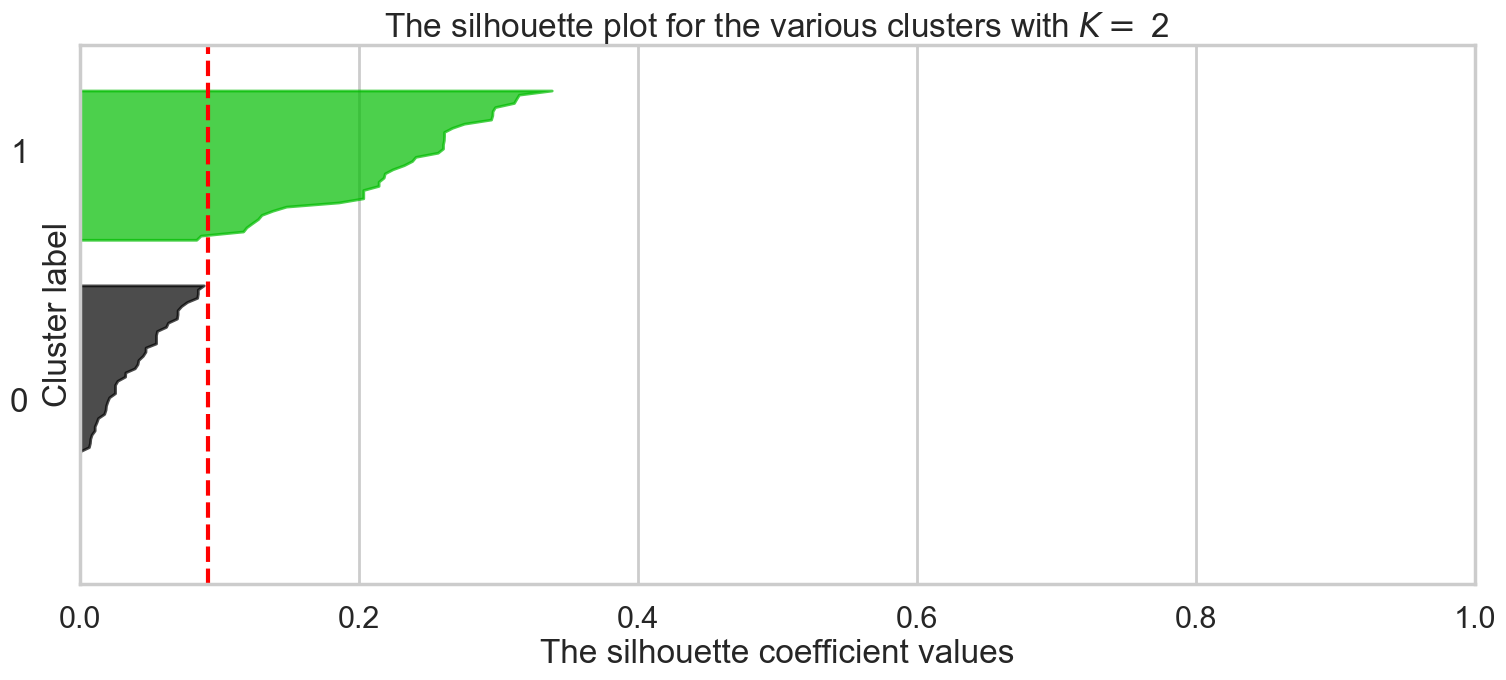

Silhouette average for K=2:  0.09174871508750351


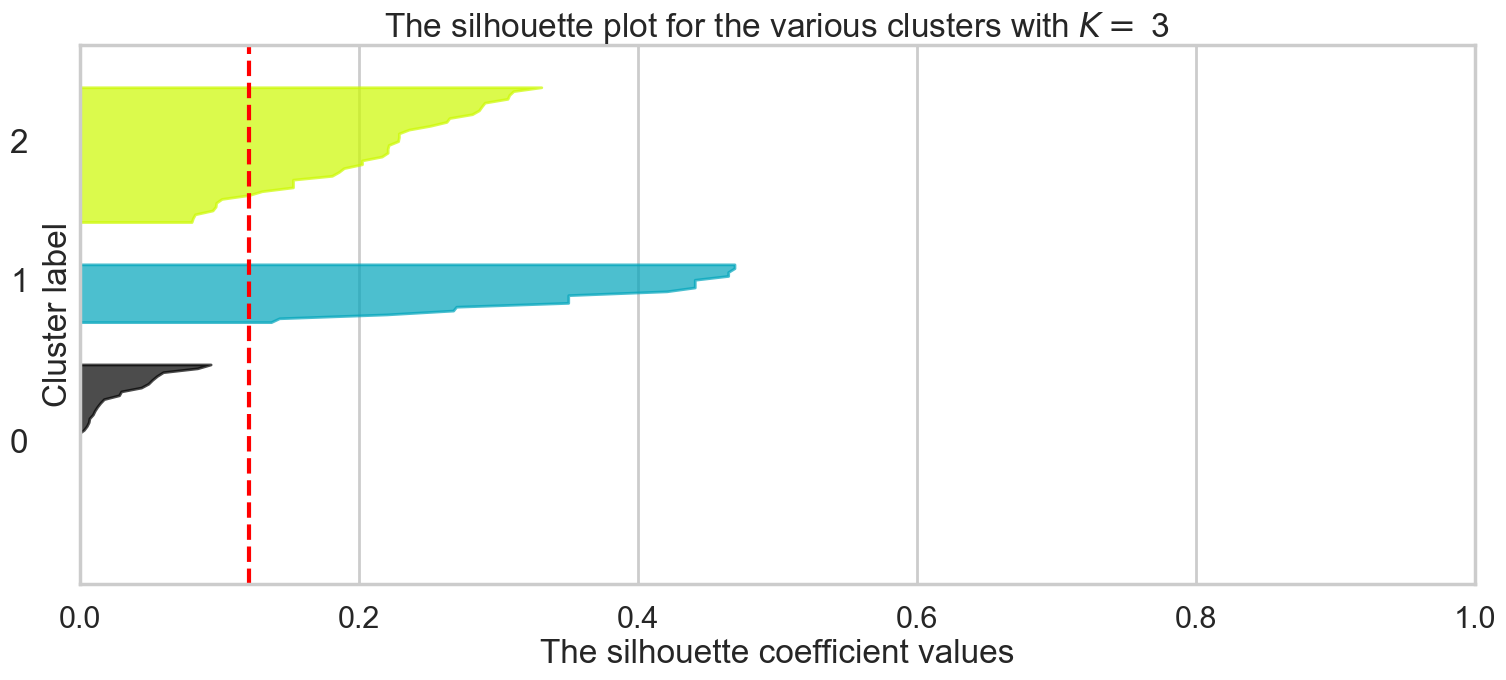

Silhouette average for K=3:  0.12101628521627421


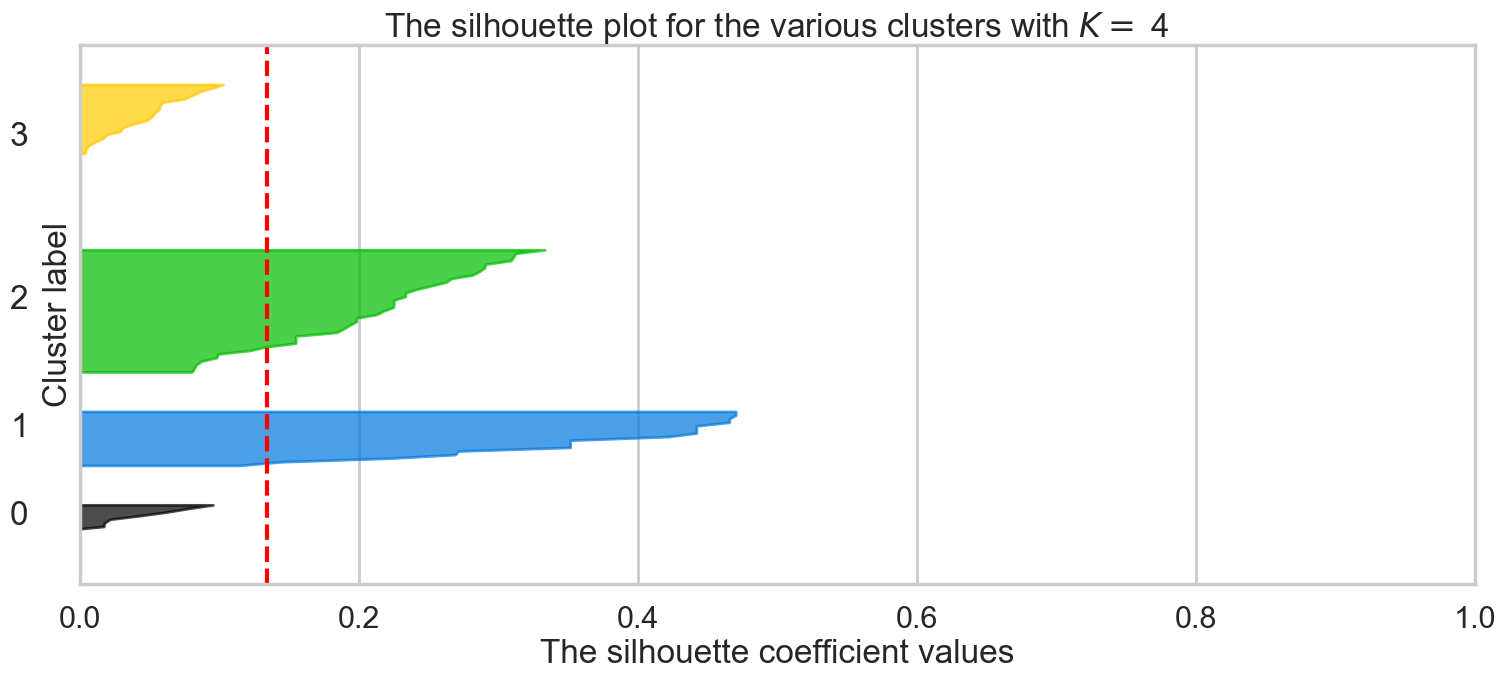

Silhouette average for K=4:  0.13421536289944658


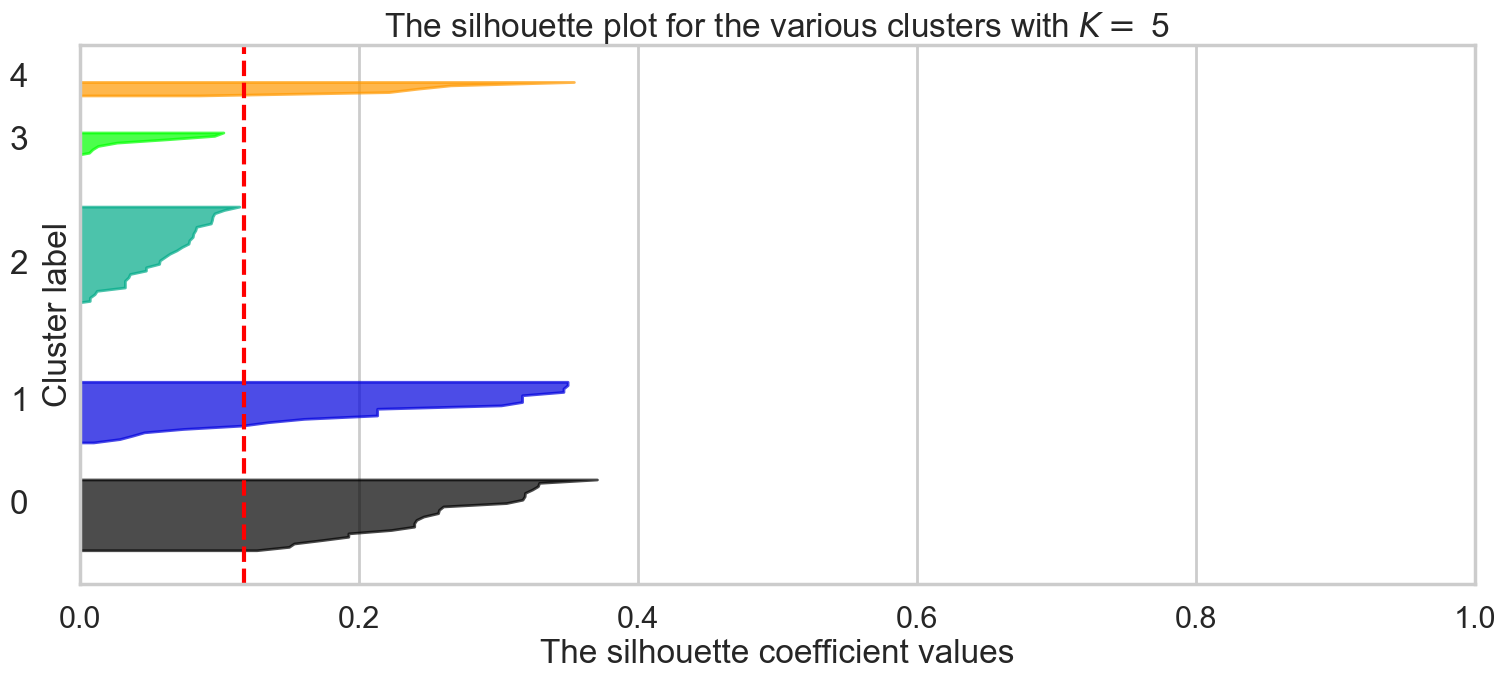

Silhouette average for K=5:  0.11749792889789946


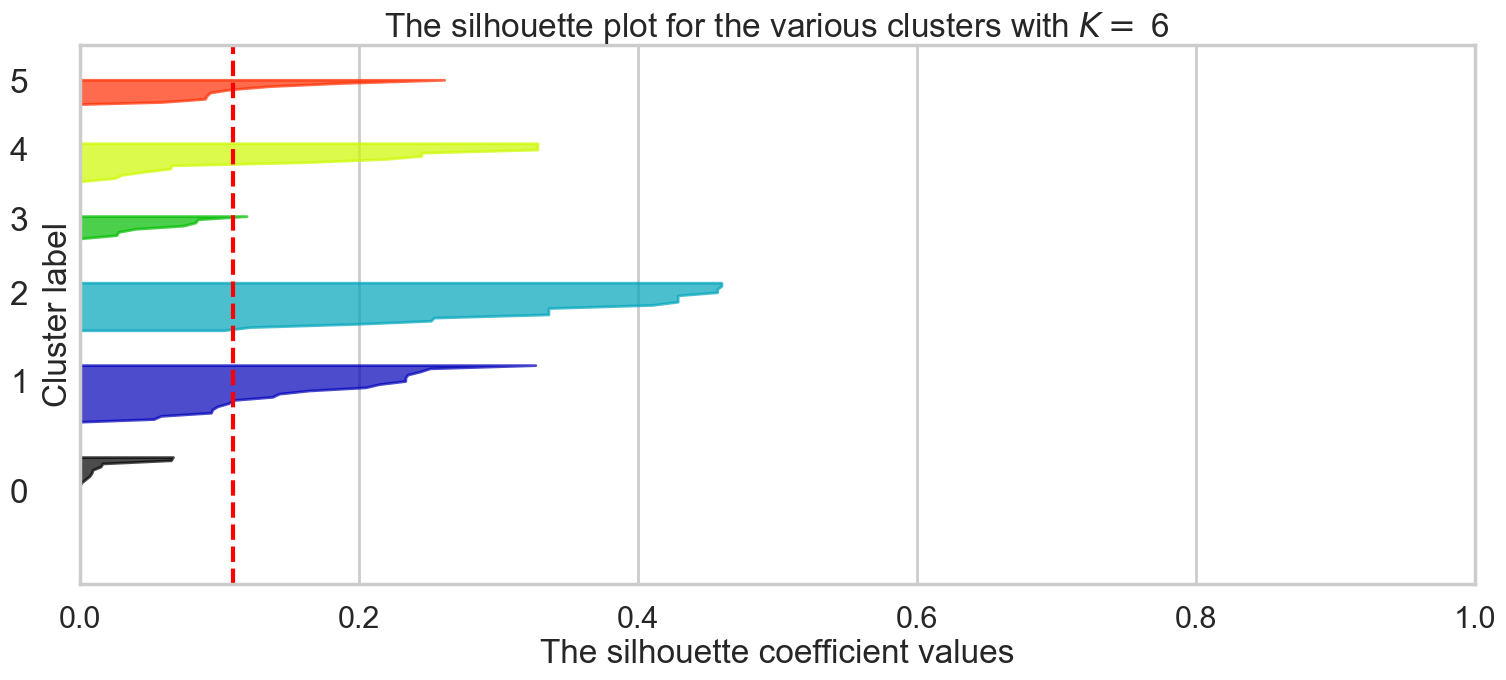

Silhouette average for K=6:  0.11001951281555851


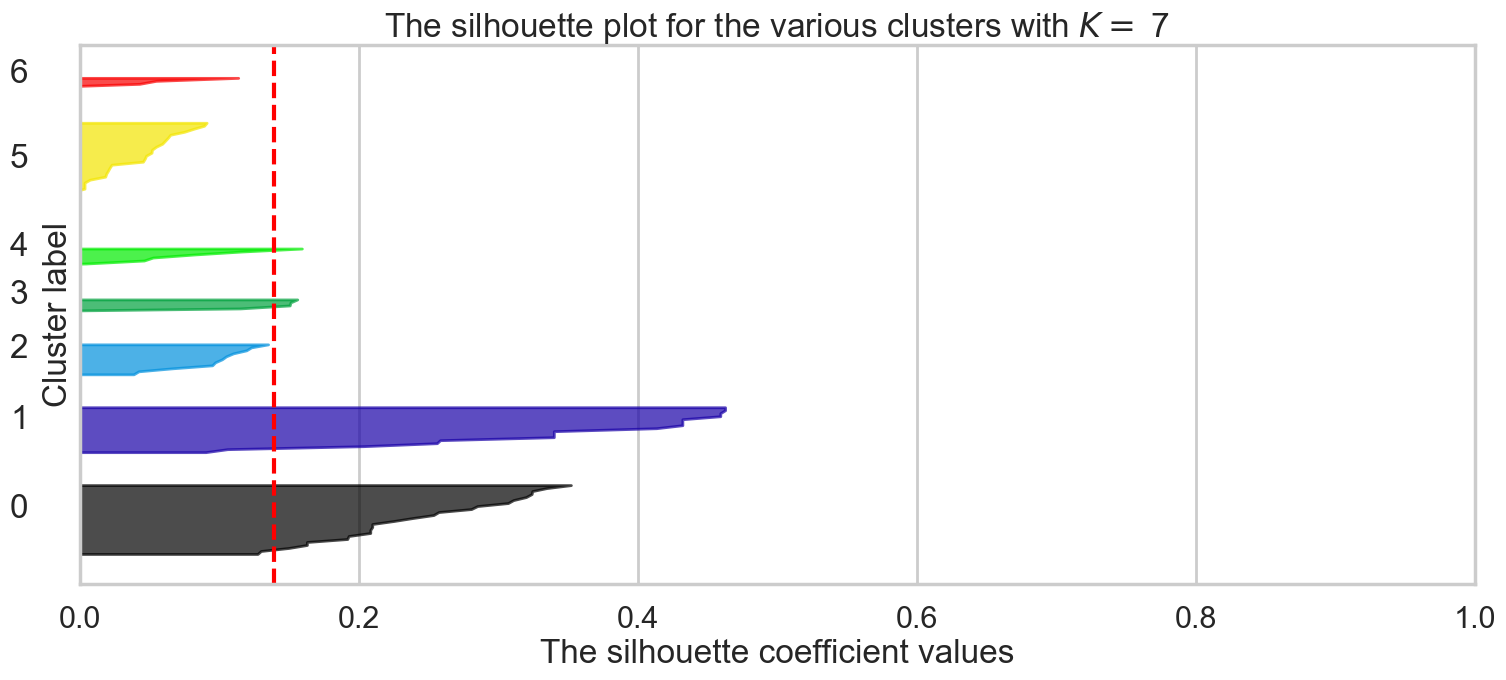

Silhouette average for K=7:  0.1389060957347788


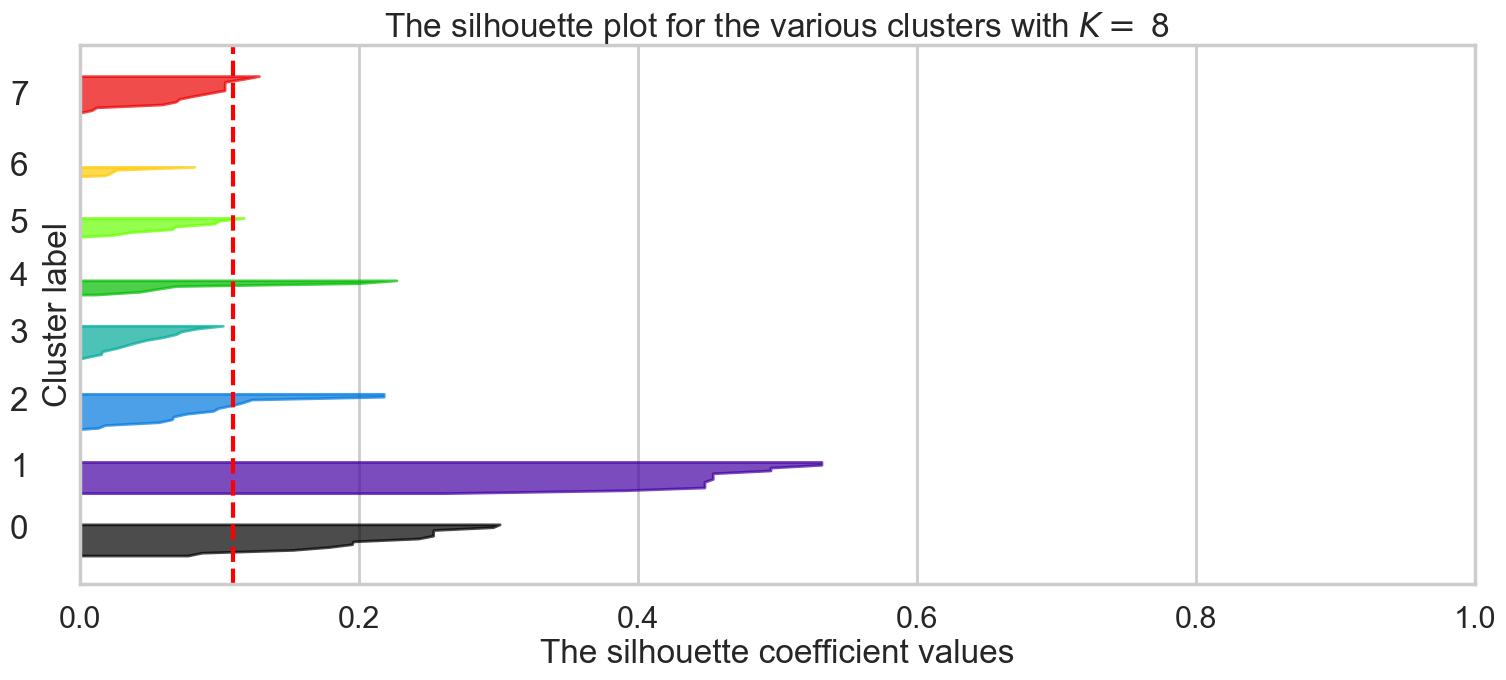

Silhouette average for K=8:  0.10969644130551678


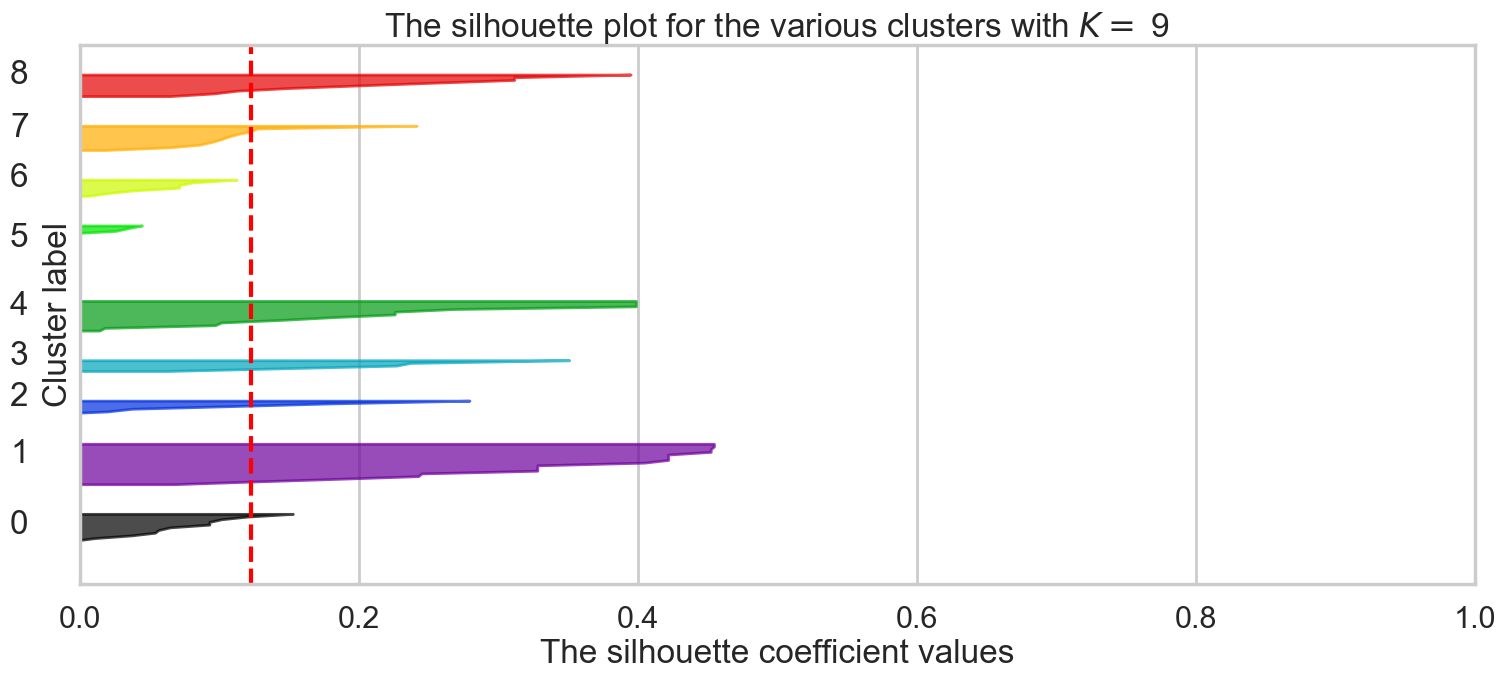

Silhouette average for K=9:  0.12267242922234355


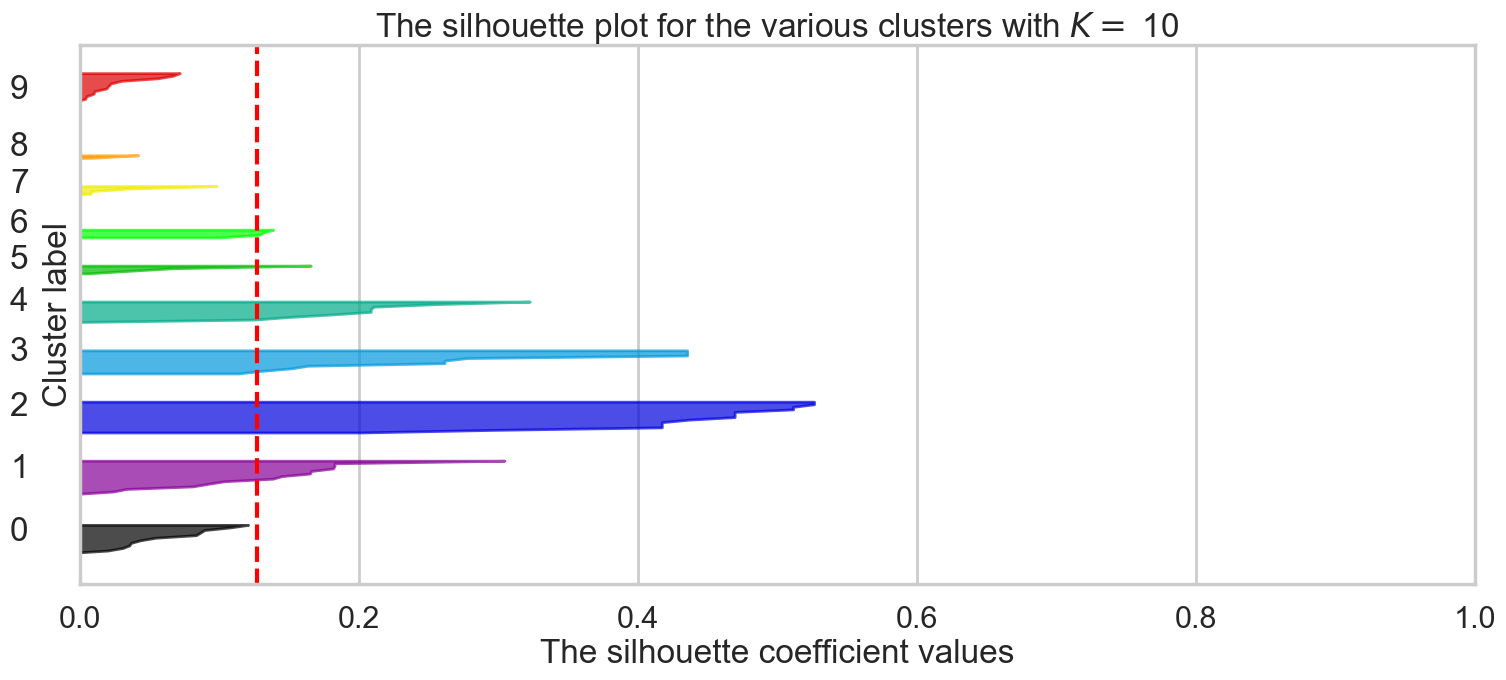

Silhouette average for K=10:  0.12728046874135684


In [26]:
K = range(2,11)
num_k = len(K)
avg_sil_score = np.zeros(num_k)
n = len(x_cols)

# run KMeans for each K
for i in range(num_k):
    n_clusters = K[i]
    
    # fit model 
    kmeans = KMeans(n_clusters=n_clusters, tol=1e-4, random_state=0).fit(x_cols)
    # get labels
    cluster_labels = kmeans.labels_
    # get average silhouette score
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    avg_sil_score[i] = silhouette_avg
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    # silhouette plot
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [0.0, 1]
    ax1.set_xlim([0.0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, n + (n_clusters + 1) * 10])
    
    y_lower = 10
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters with $K=$ %d" % n_clusters)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    print("Silhouette average for K=%d: " % n_clusters, silhouette_avg)
    

Note: we did not plot the actual data points since there are more than 2 features in our dataset.

Average Silhouette score for each $K$

In [27]:
avg_sil_score

array([0.09174872, 0.12101629, 0.13421536, 0.11749793, 0.11001951,
       0.1389061 , 0.10969644, 0.12267243, 0.12728047])

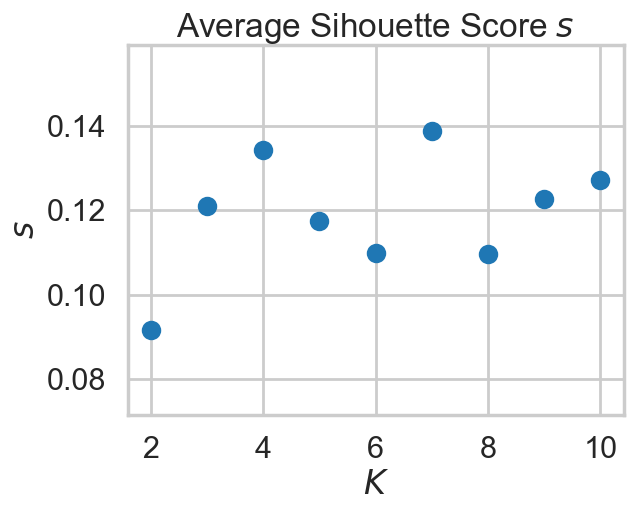

In [28]:
plt.scatter(K,avg_sil_score)
plt.xlabel("$K$")
plt.ylabel("$s$")
plt.title("Average Sihouette Score $s$" )
plt.show()

From the silhouette plots, it suggest we choose $K=7$ as it gives is the highest average silhouette score.  
This differs from the score ($K=9$) we chose using the elbow method. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [29]:
# your turn

In [30]:
from sklearn.decomposition import PCA

Reduce the dimensionality of the clustering data to 2 components

In [31]:
pca = PCA(n_components=2)
pca.fit(x_cols)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.14386393 0.10800289]
[6.36829969 5.51779083]


In [32]:
# project the dataset on the 1st 2 principal components 
x_cols_2comp_proj = pca.transform(x_cols)
print(x_cols_2comp_proj.shape)

# split the projected data into 2 vectors/columns
x,y = np.hsplit(x_cols_2comp_proj, 2)
x = x.reshape(-1,)
y = y.reshape(-1,)

# reconstruct the data from the projected data back into its original dimensions
x_cols_recon = pca.inverse_transform(x_cols_2comp_proj)
print(x_cols_recon.shape)

(100, 2)
(100, 32)


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

For each value of $K$ create new dataframe with `customer_name`, `cluster_id`, and our 2 principal components `x` and `y`.  
Only need to update the `cluster_id` each time we fit with cluster size $K$.

In [33]:
df_pca_cluster = pd.DataFrame([df_customer_profile.index, cluster_labels, x, y]).T
df_pca_cluster.columns = ["customer_name", "cluster_id","x","y"]
df_pca_cluster.head()

,customer_name,cluster_id,x,y
0,Adams,1,1.00758,0.108215
1,Allen,9,-0.287539,0.0447145
2,Anderson,2,-0.392032,1.03839
3,Bailey,4,0.699477,-0.0225422
4,Baker,4,0.0881832,-0.471695


PCA dimension reduced scatter plots for $K \in [2,10]$

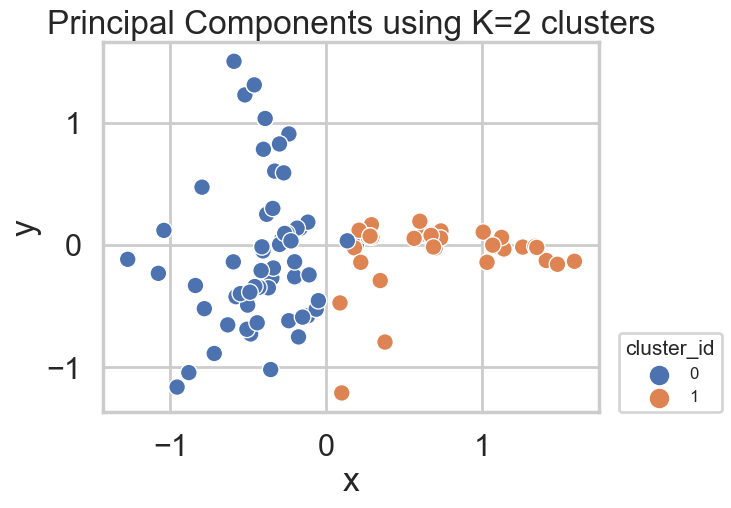

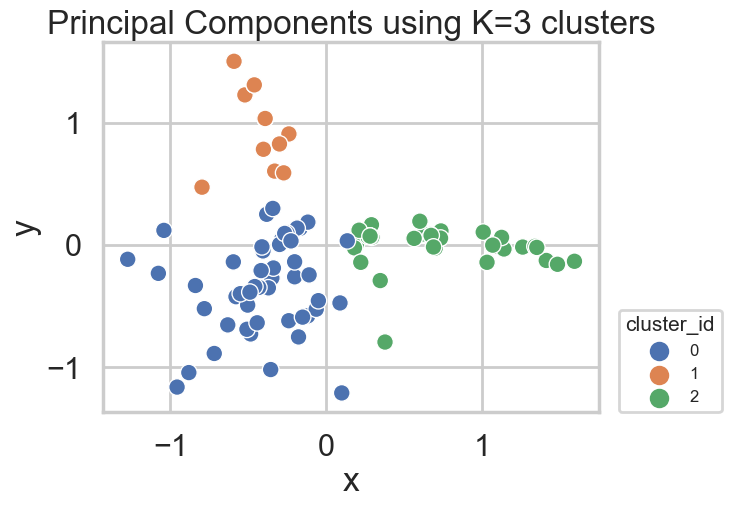

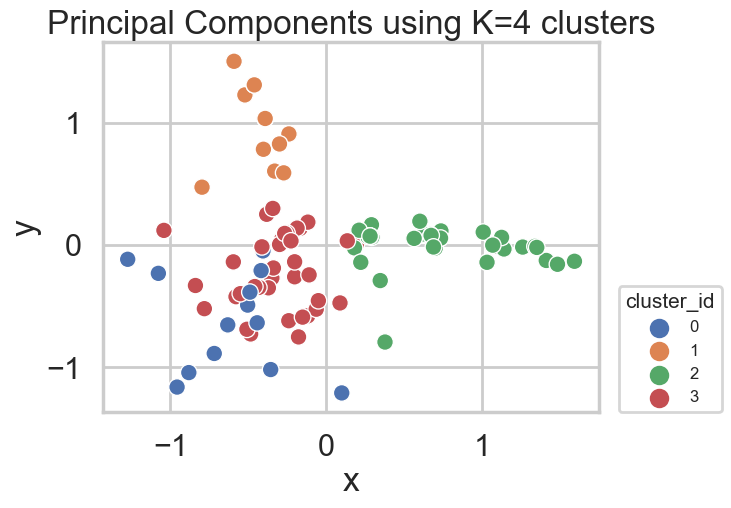

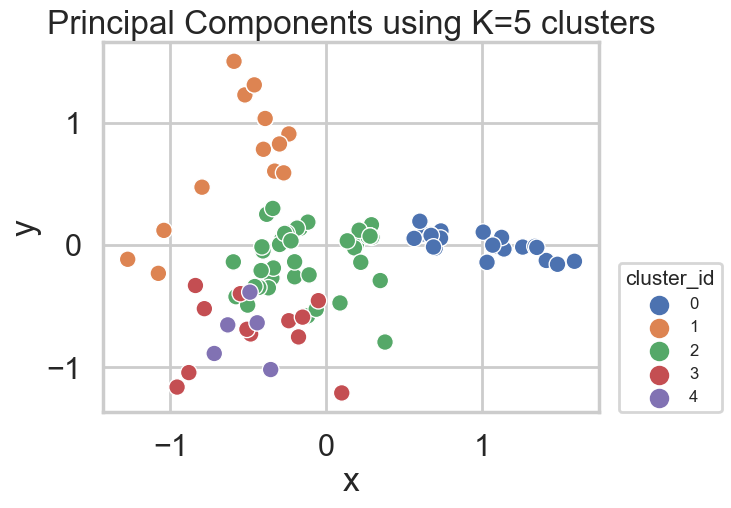

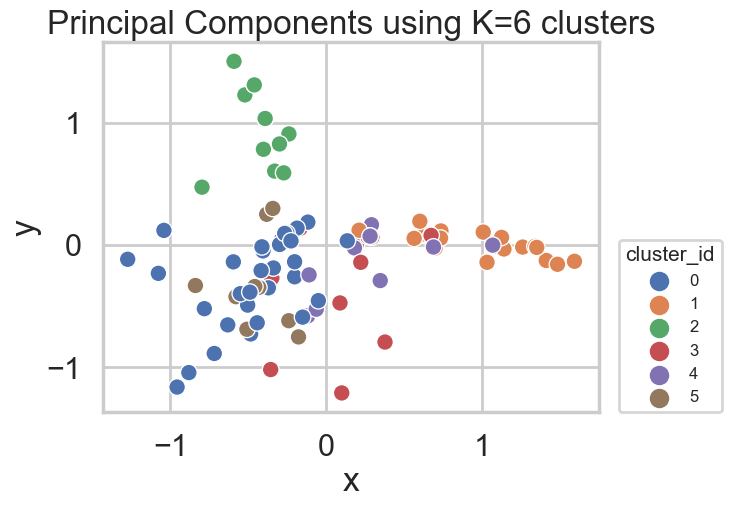

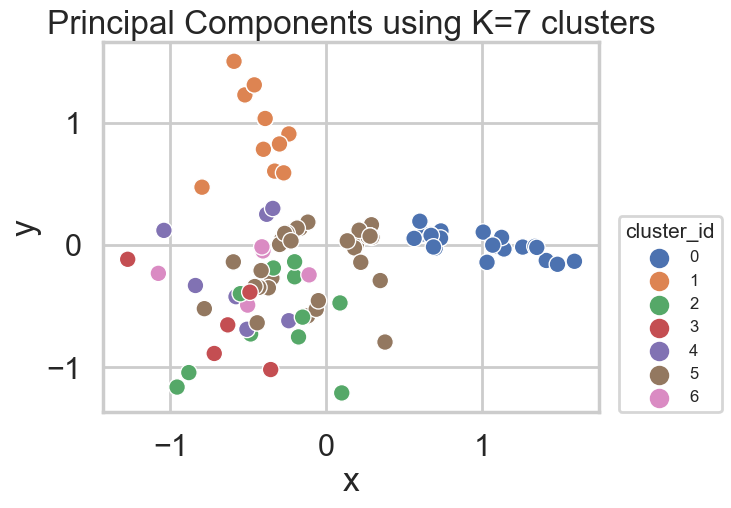

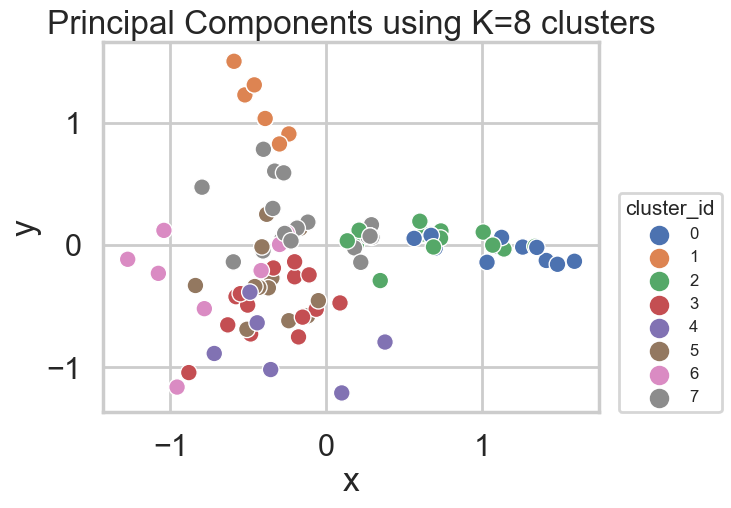

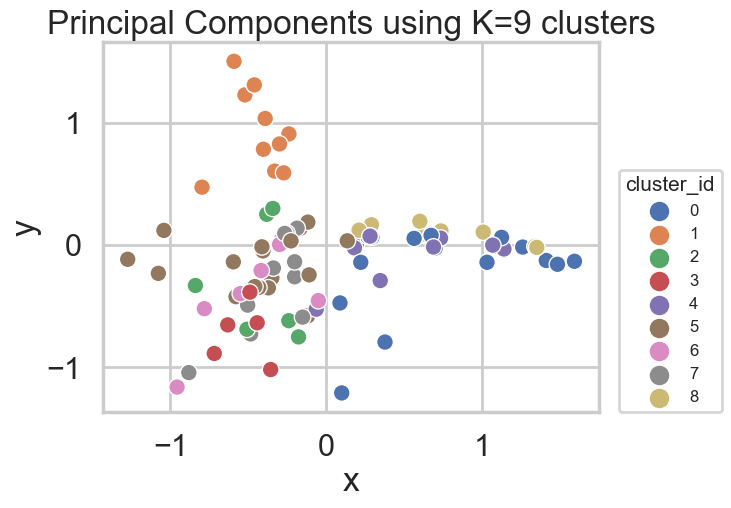

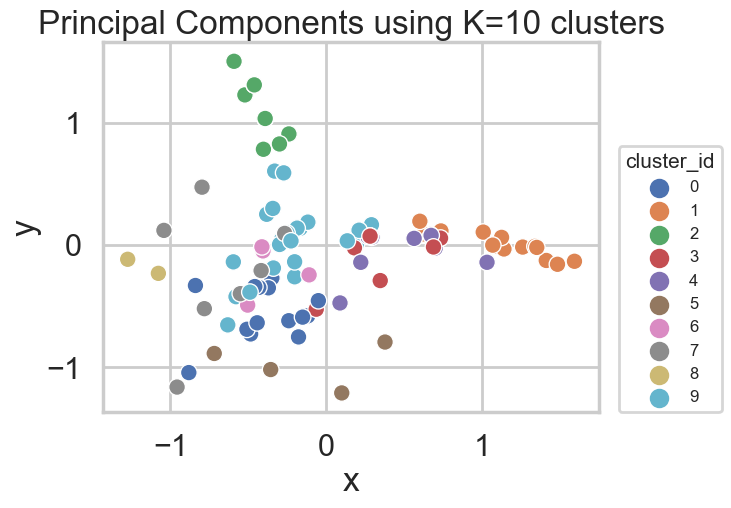

In [34]:
K = range(2,11)
num_k = len(K)

# run KMeans for each K
for i in range(num_k):
    n_clusters = K[i]
    
    # fit model 
    kmeans = KMeans(n_clusters=n_clusters, tol=1e-4, random_state=0).fit(x_cols)
    # get labels
    cluster_labels = kmeans.labels_
    # update cluster_id in dataframe 
    df_pca_cluster.cluster_id = cluster_labels
    # plot the x and y principal components
    sns.scatterplot(data=df_pca_cluster, x='x', y='y', hue='cluster_id', palette="deep")
    plt.title("Principal Components using K=%d clusters"%n_clusters)
    plt.legend(loc=(1.04, 0), title="cluster_id", fontsize=12, title_fontsize=15)
    plt.show()
    

Based on what you see, what seems to be the best value for  𝐾 ?  
Moreover, which method of choosing  𝐾  seems to have produced the optimal result visually?  

Based on the plots of the 2 principal components with clusters demarcated with different colors, 
it appears that using $K=4$ clusters gives the best results. 
From its plot we can see that there is not too much overlap between the clusters, 
and the points within a cluster are not too spread out. 
For values of $K>4$, we start to see the clusters begin to overlap greatly. 

Visually, the silhouette method and PCA (with 2 principal components) produced the better results. 
However, the silhouette method seems to be more useful as it gives us a numerical value (silhouette score/coeff.) 
to gauge how well the clusters were fitted.

**Exercise:** Now look at both the original raw data about the offers and transactions and look at the fitted clusters.   
Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [35]:
# using model with K=7 clusters
kmeans = KMeans(n_clusters=7, tol=1e-4, random_state=0).fit(x_cols)
df_pca_cluster.cluster_id = kmeans.labels_

In [36]:
# compile list of offers each customer made
offers_list = [ [x+1 for x in np.nonzero(x_cols[i,:])] for i in range(len(x_cols)) ]
offers_list = np.ravel(offers_list[:])

In [37]:
# dataframe with customer_name, cluster_id (using K=7), offers_list 
df_customer_clusters = df_pca_cluster.drop(["x","y"], axis=1)
df_customer_clusters["offers_list"] = offers_list

In [38]:
df_customer_clusters.sort_values(by="cluster_id", axis=0)

,customer_name,cluster_id,offers_list
0,Adams,0,"[18, 29, 30]"
44,King,0,"[7, 13, 18, 29]"
39,James,0,"[7, 8, 13, 18, 30]"
55,Morgan,0,"[8, 29]"
37,Hughes,0,"[7, 8, 13, 29, 30]"
...,...,...,...
62,Parker,6,"[11, 16, 20, 29, 31]"
16,Cooper,6,"[4, 16, 20, 32]"
27,Gomez,6,"[11, 20, 25, 32]"
80,Sanchez,6,"[4, 5, 14, 15, 20, 22, 26]"


For each cluster, find the most frequent offer present

In [39]:
from scipy import stats as st

In [40]:
df_cluster_profile = pd.DataFrame()

for i in range(kmeans.n_clusters):
    cluster_i_offers = df_customer_clusters[df_customer_clusters["cluster_id"]==i]["offers_list"].to_numpy()
    cluster_i_offers = np.hstack(cluster_i_offers)
    mode = st.mode(cluster_i_offers)[0][0]
    df_cluster_profile[i] = pd.Series({'cluster':i, 'offer_id':mode})

In [41]:
df_cluster_profile = df_cluster_profile.T
df_cluster_profile.merge(df_offers, how='left', on='offer_id')

,cluster,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,0,30,December,Malbec,6,54,France,False
1,1,24,September,Pinot Noir,6,34,Italy,False
2,2,31,December,Champagne,72,89,France,False
3,3,4,February,Champagne,72,48,France,True
4,4,1,January,Malbec,72,56,France,False
5,5,22,August,Champagne,72,63,France,False
6,6,20,August,Cabernet Sauvignon,72,82,Italy,False


Just observing the offer that appeared the most in each cluster, we get the above dataframe. 
From this we can see that most of the clusters prefer **French** or **Italian** wine and also wine that is still in **peak**. 

Moreover for a better profile of each cluster, we can look at the top 3 most purchased offers or even the plot a histogram for each cluster of all the offers purchased. 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [42]:
#your turn

In [43]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

PCA()

Plot `explained_variance_` to find the elbow point

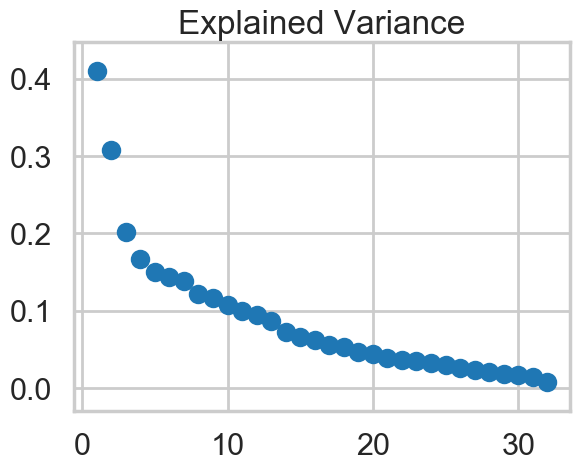

In [44]:
# explained variance
var = pca.explained_variance_
plt.scatter(range(1,len(var)+1), var)
plt.title('Explained Variance')
plt.show()

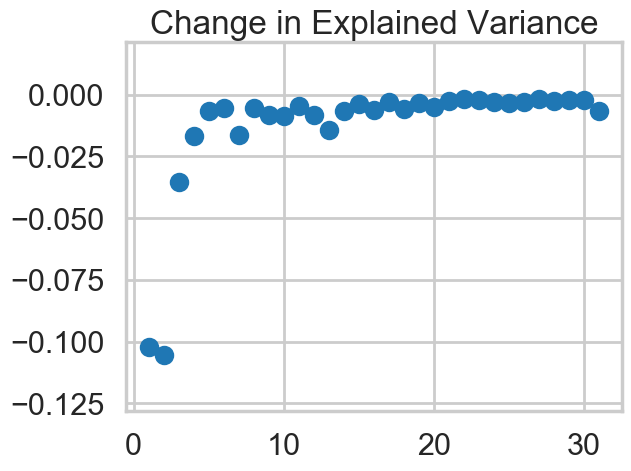

In [45]:
# change in explained variance
d_var = var[1:]-var[:-1]
plt.scatter(range(1,len(d_var)+1), d_var)
plt.title('Change in Explained Variance')

plt.show()

From the plot of the explained variance, the elbow point occurs at around `7` (principal components).  
Let's go ahead and project the data onto the 1st 7 principal components.  

In [46]:
pca = PCA(n_components=7)
pca.fit(x_cols)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.14386393 0.10800289 0.07104281 0.05866151 0.05273181 0.05037351
 0.04853032]
[6.36829969 5.51779083 4.47514997 4.06653164 3.85552796 3.76832758
 3.69874274]


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>

In [47]:
# Your turn

1. [Affinity propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)

In [48]:
from sklearn.cluster import AffinityPropagation as AP

In [49]:
ap = AP().fit(x_cols)
ap_cluster_labels = ap.labels_
ap_cluster_ctrs = ap.cluster_centers_
print(len(ap_cluster_ctrs), "clusters")

14 clusters


In [50]:
# silhouette score
print("Silhouette Coefficient: %0.3f" % silhouette_score(x_cols, ap_cluster_labels, metric="sqeuclidean") )

Silhouette Coefficient: 0.177


The silhouette score is very low, meaning no substantial structure has been found using Affinity Propagation. 

In [51]:
df_ap_cluster = df_pca_cluster
df_ap_cluster.cluster_id = ap_cluster_labels

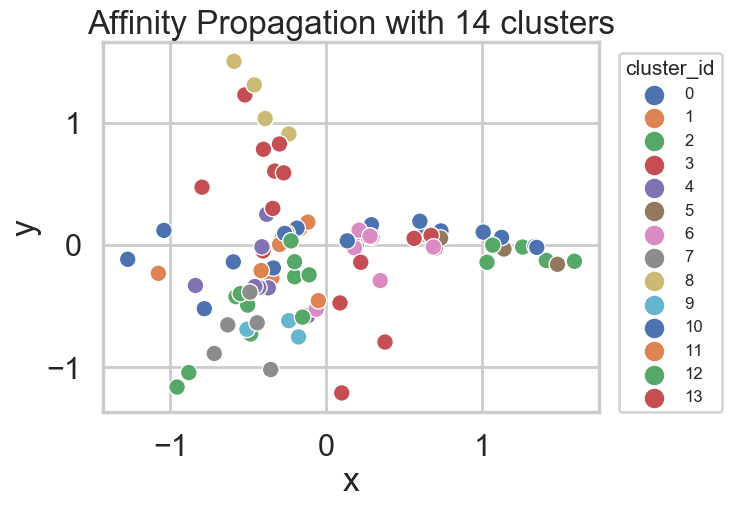

In [52]:
# plot Affinity propagation clusters using the 2 principal component projections
sns.scatterplot(data=df_ap_cluster, x='x', y='y', hue='cluster_id', palette="deep")
plt.title("Affinity Propagation with %d clusters" % len(ap_cluster_ctrs))
plt.legend(loc=(1.04, 0), title="cluster_id", fontsize=12, title_fontsize=15)
plt.show()

2. [Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)  
Let us use `n_clusters=7`,  
`n_components=7` as the number of eigenvectors to use for the spectral embedding,  
and `assign_labels='kmeans'` (default) for assigning labels to the clusters


In [53]:
from sklearn.cluster import SpectralClustering as SC

In [54]:
sc = SC(n_clusters=7, n_components=7).fit(x_cols)
sc_cluster_labels = sc.labels_

In [55]:
# silhouette score
print("Silhouette Coefficient: %0.3f" % silhouette_score(x_cols, sc_cluster_labels, metric="sqeuclidean") )

Silhouette Coefficient: 0.090


Really low silhouette score

3. [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [56]:
from sklearn.cluster import AgglomerativeClustering as AC

In [57]:
ac = AC().fit(x_cols)
ac_cluster_labels = ac.labels_
print(ac.n_clusters_, "clusters") 

2 clusters


In [58]:
# silhouette score
print("Silhouette Coefficient: %0.3f" % silhouette_score(x_cols, ac_cluster_labels, metric="sqeuclidean") )

Silhouette Coefficient: 0.123


The silhouette score is very low, but let's plot the method clustered since the data into 2 clusters

In [59]:
df_ac_cluster = df_pca_cluster
df_ac_cluster.cluster_id = ac_cluster_labels

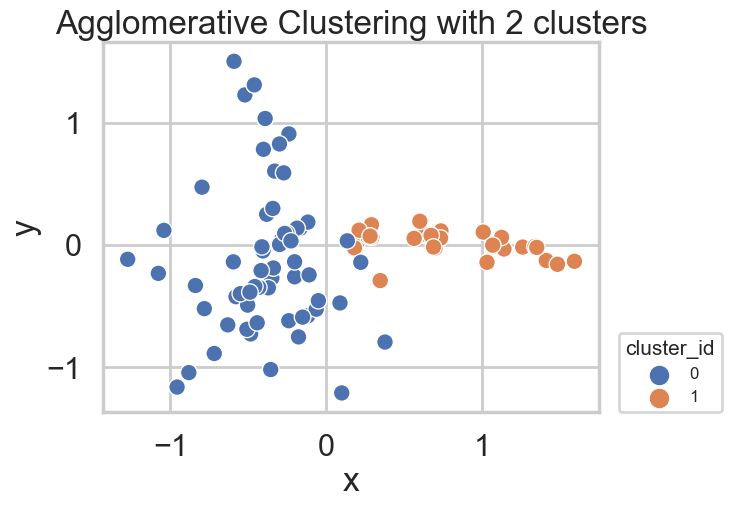

In [60]:
# plot Agglomerative clustering clusters using the 2 principal component projections
sns.scatterplot(data=df_ac_cluster, x='x', y='y', hue='cluster_id', palette="deep")
plt.title("Agglomerative Clustering with %d clusters" % ac.n_clusters_)
plt.legend(loc=(1.04, 0), title="cluster_id", fontsize=12, title_fontsize=15)
plt.show()

4. [DBSCAN](https://scikit-learn.org/stable/modules/generated/dbscan-function.html#sklearn.cluster.dbscan)

In [61]:
from sklearn.cluster import dbscan as DBSCAN

Let's use `eps=1.2` as the maximum distance between two samples for one to be considered as in the neighborhood of the other

In [62]:
dbscan_core_samples, dbscan_labels = DBSCAN(x_cols, eps=1.2)
print("Labels: ", dbscan_labels) 

Labels:  [ 0 -1  1  2 -1 -1  1  2 -1  2 -1  1  2 -1 -1  1 -1  1  0 -1  2  2 -1 -1
  1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1  2 -1 -1  1  1  2 -1 -1 -1  2 -1
 -1 -1 -1 -1 -1  1 -1  2  1  3  0 -1 -1  2 -1  0  0 -1  1 -1 -1 -1 -1 -1
 -1  3 -1  2  1 -1 -1  1 -1 -1 -1  1  2 -1  0 -1 -1  2 -1  0 -1  2 -1 -1
  2 -1 -1 -1]


DBSCAN model returned `-1` for many of the sample labels, meaning there was too much noise in the data. 
The points labelled -1, may be too far from any other data points and thus do not fit into any clusters. 
If we increase the neighborhood size (i.e. eps) to say `eps`$\approx$ 2.0, then all the points will be clustered into 1 large cluster, which is not helpful. 

Thus DBSCAN is probably not a good model to use to cluster the dataset. It is probably a more useful model if we were doing anomaly detection.  

#### Exercise VI results

Since we do not have the actual labels of the samples, let's compare the models' results by comparing their silhouette scores. 
Of the 4 models above, it appears **Affinity Propagation** performed the best with the highest silhouette score of 0.173 (which is not a good score). It may have performed the best because it used more clusters (14) than the other models, and thus probably overfit the data. 

Looking at the 2d scatterplot of the Affinity Propagation clusters (using the PCA projection), the clusters overlap quite a lot, but again that is using projections onto only 2 principal components. The 2d scatterplot of the Agglomerative Clustering models looks much better with minimal overlap, but it separates the data into only 2 clusters with distances between projected data points quite far from each other. 